#### Imports

In [90]:
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

import numpy as np
from numpy import pi

#### create class to represent quantum Fourier Transform (QFT)

In [91]:
class QFT():
    def __init__(self, circuit, n):
        self.circuit = circuit
        self.n = n    # n represents the number to be converted.
        self.n_og = n
        self.circuit_2 = QuantumCircuit(self.n)
    
    def swap_registers(self, qc_2=False):
        if qc_2:
            for qubit in range(self.n//2):
                self.circuit_2.swap(qubit, self.n-qubit-1)
        
        else:
            for qubit in range(self.n//2):
                self.circuit.swap(qubit, self.n-qubit-1)
        
    def qft_rotations(self, qc_2=False):
        if qc_2:
            if self.n == 0:
                return self.circuit_2
            self.n -=1
            self.circuit_2.h(self.n)

            for qubit in range(self.n):
                self.circuit_2.cp(pi/2**(self.n-qubit), qubit, self.n)
            
            self.qft_rotations(qc_2)

        else:
            if self.n == 0:
                return self.circuit
            self.n -= 1
            self.circuit.h(self.n)
            for qubit in range(self.n):
                self.circuit.cp(pi/2**(self.n-qubit), qubit, self.n)
        
            self.qft_rotations()

    def inverse_qft(self):
        # Performing QFT on new circuit.
        self.qft_rotations(True)    # TODO: Create variable in __init__ to account for variable here ------>
        self.swap_registers(True)

        # Inverting.
        self.circuit_2 = self.circuit_2.inverse()
        
        self.circuit.append(self.circuit_2, self.circuit.qubits[:self.n_og])

        return self.circuit.decompose()

    def __call__(self):
        return self.inverse_qft()

#### apply circuit to class

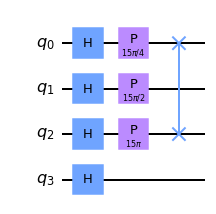

In [92]:
n_qubits = 4
number = 15

qc = QuantumCircuit(n_qubits)

for qubit in range(n_qubits):
    qc.h(qubit)
qc.p(number*pi/4, 0)
qc.p(number*pi/2, 1)
qc.p(number*pi, 2)
qc.swap(0, 2)

qc.draw(output='mpl')


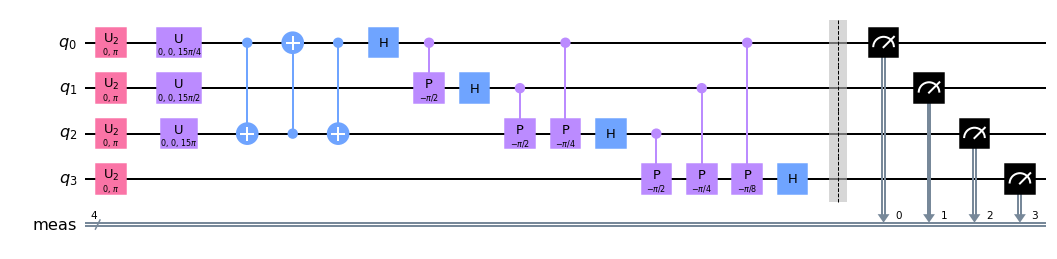

In [93]:
qc = QFT(qc, n_qubits)()
qc.measure_all()

qobj = assemble(qc)
qc.draw(output='mpl')

#### simulate circuit

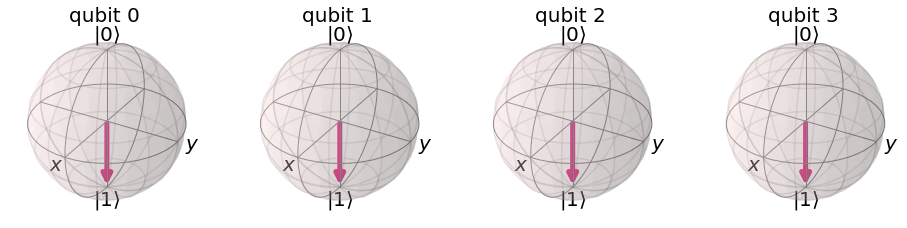

In [94]:
simulator= Aer.get_backend('statevector_simulator')

statevector = simulator.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)